### Introduction to Knoweldge Graphs

- CS 575
- Mike Goodrich
- Brigham Young University
- March 2025

The purpose of this tutorial is to introduce the basics of knowledge graphs. We'll use data from the [Kaggle movies dataset](https://www.kaggle.com/datasets/rajugc/imdb-top-250-movies-dataset) and [Kaggle movies code example](https://www.kaggle.com/code/rajugc/imdb-top-250-movies-eda). The code is released under the Apache 2.0 open source license.

This tutorial uses some of the code from the Kaggle data set, but also uses code patterned after chapter 2 in _Graph Data Science with Neo4j_, Estell Scifo, Packt Publiching Ltd., 2023.

---

#### Requirements

The code requires the following modules
- os
- matplotlib
- pandas
- the network partitioning code used class
- the network visualization code used in class

---

#### Graph Data Science Process

DISCLAIMER: Graph data science is a relatively new area for me. This means that you should view the process I present as my working mental model rather than something that you should treat as some kind of universal approach.

The following figure is a flowchart of my mental model of the graph data science process. 

<img src="figures/Graph_data_science_process.png" alt="A flowchart of the data science process" width = "500">


#### Gather and Clean Data

The first step is to extract data from whatever source you have into usable form. This could require desiging a webcrawler to scrape Netflix recommendations, interfacing through an API to obtain Twitter interaction networks, writing a parser to turn a set of Google scholar pages into csv file, or querying an existing cloud database to find how topics on Wikipedia are related.  This can be labor-intensive and can require a high level of skill, but fortunately there are now many AI-based tools that help a lot with this process. 

We'll use the _movies dataset_ from the Kaggle project, so let's get familiar with it.


**Inspect some rows and columns in the dataset**

In [194]:
import pandas as pd

df: pd.DataFrame = pd.read_csv('movies_data/IMDB Top 250 Movies.csv') # prefix this file name with the directory in which you stored it
df.head()   # This function returns the first n rows for the object based on position. 
            # It is useful for quickly testing if your object has the right type of data in it.
            # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html

,rank,name,year,rating,genre,certificate,run_time,tagline,budget,box_office,casts,directors,writers
0,1,The Shawshank Redemption,1994,9.3,Drama,R,2h 22m,Fear can hold you prisoner. Hope can set you f...,25000000,28884504,"Tim Robbins,Morgan Freeman,Bob Gunton,William ...",Frank Darabont,"Stephen King,Frank Darabont"
1,2,The Godfather,1972,9.2,"Crime,Drama",R,2h 55m,An offer you can't refuse.,6000000,250341816,"Marlon Brando,Al Pacino,James Caan,Diane Keato...",Francis Ford Coppola,"Mario Puzo,Francis Ford Coppola"
2,3,The Dark Knight,2008,9.0,"Action,Crime,Drama",PG-13,2h 32m,Why So Serious?,185000000,1006234167,"Christian Bale,Heath Ledger,Aaron Eckhart,Mich...",Christopher Nolan,"Jonathan Nolan,Christopher Nolan,David S. Goyer"
3,4,The Godfather Part II,1974,9.0,"Crime,Drama",R,3h 22m,All the power on earth can't change destiny.,13000000,47961919,"Al Pacino,Robert De Niro,Robert Duvall,Diane K...",Francis Ford Coppola,"Francis Ford Coppola,Mario Puzo"
4,5,12 Angry Men,1957,9.0,"Crime,Drama",Approved,1h 36m,Life Is In Their Hands -- Death Is On Their Mi...,350000,955,"Henry Fonda,Lee J. Cobb,Martin Balsam,John Fie...",Sidney Lumet,Reginald Rose


**Look up the headers for each column in the dataset**

In [195]:
print(list(df.columns))

['rank', 'name', 'year', 'rating', 'genre', 'certificate', 'run_time', 'tagline', 'budget', 'box_office', 'casts', 'directors', 'writers']


**Inspect what kind of information is stored in each column of the dataset**

In [196]:
df.info()
# This method prints information about a DataFrame including the index dtype and 
# columns, non-null values and memory usage.
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rank         250 non-null    int64  
 1   name         250 non-null    object 
 2   year         250 non-null    int64  
 3   rating       250 non-null    float64
 4   genre        250 non-null    object 
 5   certificate  250 non-null    object 
 6   run_time     250 non-null    object 
 7   tagline      250 non-null    object 
 8   budget       250 non-null    object 
 9   box_office   250 non-null    object 
 10  casts        250 non-null    object 
 11  directors    250 non-null    object 
 12  writers      250 non-null    object 
dtypes: float64(1), int64(2), object(10)
memory usage: 25.5+ KB


**Look at some summary information about which genres are present in the _genres_ column**

In [197]:
df.value_counts('genre')

genre
Drama                         19
Crime,Drama                   14
Animation,Adventure,Comedy    10
Biography,Drama,History        9
Crime,Drama,Mystery            9
                              ..
Crime,Mystery,Thriller         1
Crime,Sci-Fi                   1
Adventure,Comedy,Sci-Fi        1
Adventure,Comedy,Fantasy       1
Adventure,Comedy,Drama         1
Name: count, Length: 104, dtype: int64

What kind of info is stored in `certificate` and is it always populated?

In [198]:
certificate_set: set[str] = set()
for i in df['certificate']:
    certificate_set.add(i)
print(certificate_set)

{'TV-PG', 'Not Rated', 'Passed', '18+', 'TV-MA', 'G', 'X', 'GP', 'PG-13', 'Approved', 'PG', '13+', 'Unrated', 'R', 'Not Available'}


---

#### Create Graph Schema

A _graph database_ is just a graph model of the database. The naive way to construct the graph database is to create a node for each row and column entry, and then add edges between nodes on the same row. In practice, this is not effective because only some of the relationships between the data in the columns is of interest. 

We approach this by creating a schema that describes the relationships that we care about (see Neo4j book, page 31). The schema should be set up in a way that allows us to answer questions that we might ask. For the movie database, I'll use the following schema.

<img src="figures/GraphSchema.png" alt="Grapha schema for the movies database" width = "500">

This schema emphasizes movies, genres, and ratings. Notice how it ignores several of the columns in the database. Choosing a graph schema is the process of identifying the entities and relationships that you care about in the graph database.

What schemas can you construct that might tell us interesting things about the movies dataset?

---

#### Form Knowledge Graph

We now need to go through the database and create a node for each movie, genre, movie certificate, and person. There are graph database query tools for doing this (e.g., Cypher in Neo4j), but I'm trying to teach this without requiring you to learn a lot of new tools, so I wrote code that extracts movie information into _nodes_. Each node will have metadata, describing some of the infromation for what the node represents. 

We'll then create _edges_ using the "resource description framework" (RDF), which represents relationships between nodes using a _subject predicate object_ relationship template. Don't worry too much about what this means right now because I haven't implemented edge labeling in my code. 

**Create Graph:** The edge types in the graph schema are directed, but the relationship between items in the database is undirected. We'll create an undirected graph. If we were labeling edge types, we'd need to create a directed graph because `actor "is_in" movie` differs from `movie "had_in_it" actor`. 


In [199]:
import networkx as nx
G: nx.Graph = nx.Graph()

**Get Nodes:** The database has 13 columns, but our graph schema indicates that we are only interested in four: genre, movie, certification, and person. Define a function that takes a list of categories and creates a node for each type.

In [200]:
def get_nodes_from_categories(category_list: list[str],
                              dataframe: pd.DataFrame,
                              G: nx.Graph
                              ) -> nx.Graph:
    for category in category_list:
        node_count: int = len(G)
        node_list: list[str] = get_nodes_from_category(category, dataframe)
        for node in node_list:
            G.add_node(node_count, node_name = node, node_type = str(category))
            node_count += 1
    return G

def get_nodes_from_category(category: str,
                            dataframe: pd.DataFrame
                            ) -> list[str]:
    # Error handling
    if category not in set(df.columns):
        raise ValueError(f"Category {category} not found in the database")
    
    # Read each line in the category column
    entries = dataframe[category] 
    # There can be multiple objects listed in each line. Find the unique ones 
    entry_set: set[str] = set()   
    for entry in entries:
        for e in entry.replace('\n',',').split(","):
            entry_set.add(e)
    return sorted(list(entry_set))


The graph gets too big to visualize if all top 250 movies are used. Let's restrict it to the top 25 movies.

In [201]:
df_restricted: pd.DataFrame = df.head(25)
print(df_restricted.shape)

(25, 13)


In [202]:
categories: set[str] = {'genre', 'name', 'casts', 'directors', 'writers','certificate'}
G: nx.Graph = nx.Graph()
G = get_nodes_from_categories(categories,df_restricted,G) 
print(len(G))

522


There are a lot of nodes in the graph so drawing it will be slow, so let's do a really simple graph layout.

In [203]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def show_graph(G: nx.Graph, categories: list[str]) -> None:
    color_template: dict[str, str] = {'genre': 'lightblue', 
                                    'writers': 'y', 
                                    'name': 'salmon', 
                                    'casts': 'm', 
                                    'directors': 'c',
                                    'certificate': 'olive'}
    node_colors: list[str] = [color_template[G.nodes[node]['node_type']] for node in G.nodes()]

    plt.figure(figsize=(6,6))
    #pos = nx.spring_layout(G)
    pos = nx.nx_pydot.pydot_layout(G, prog="neato")
    nx.draw_networkx_nodes(G, pos, node_color = node_colors, alpha=0.5,node_size=20 )
    nx.draw_networkx_edges(G, pos, edge_color="lightgray", width=0.5)
    legend_patches = [mpatches.Patch(color=color, label=category) for category, 
                    color in color_template.items() if category in categories]

    # Add the legend
    _ = plt.legend(handles=legend_patches, title="Node Types", loc="upper left")

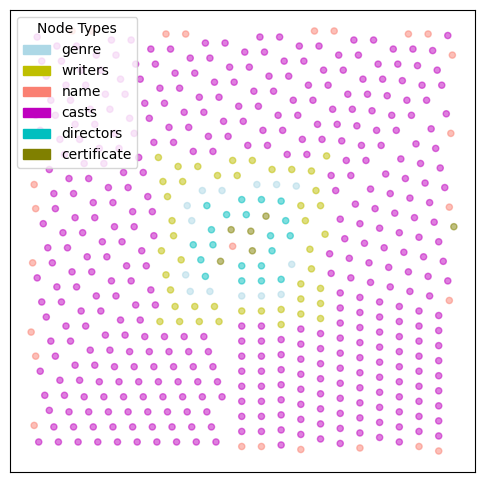

In [204]:
show_graph(G, categories)

**Add Edges:** There should be an edge between every pair of nodes that occur on the same line of the database. 

In [205]:
def get_edges(category_1: str,
              category_2: str,
              df: pd.DataFrame
              ) -> list[tuple[str, str]]:
    # Step 1: Error handling
    if category_1 not in set(df.columns):
        raise ValueError(f"Category {category_1} not found in the database")
    if category_2 not in set(df.columns):
        raise ValueError(f"Category {category_2} not found in the database")
    if category_1 == category_2:
        raise ValueError(f"Category 1 and category 2 are the same: {category_1}")
    
    # Step 2: identify pairwise relationships
    entries_1 = df[category_1]
    entries_2 = df[category_2]
    set_of_edges = set()
    for i in range(len(entries_1)):
        iterator_1 = set(entries_1[i].replace('\n',',').split(","))
        iterator_2 = set(entries_2[i].replace('\n',',').split(","))
        for e1 in iterator_1:
            for e2 in iterator_2:
                set_of_edges.add((str(e1),str(e2)))
    return set_of_edges

    

In [206]:
from itertools import combinations
from typing import Hashable

def find_node_by_attributes(G: nx.Graph, name: str, node_type:str) -> Hashable | None:
    for node, attrs in G.nodes(data=True):
        if attrs.get("node_name") == name and attrs.get("node_type") == node_type:
            return node
    return None  # Return None if no matching node is found

def add_edges(categories: set[str], df: pd.DataFrame, G: nx.Graph) -> nx.Graph:
    for category_1, category_2 in list(combinations(categories,2)):
        for edge in get_edges(category_1, category_2, df):
            node1 = find_node_by_attributes(G, edge[0], category_1)
            node2 = find_node_by_attributes(G, edge[1], category_2)
            if node1 is None:
                print(f"node 0 is {edge[0]} wasn't found in category {category_1}")
                continue
            if node2 is None:
                print(f"node 1 is {edge[1]} wasn't found in category {category_2}")
                continue
            G.add_edge(node1, node2)
    return G

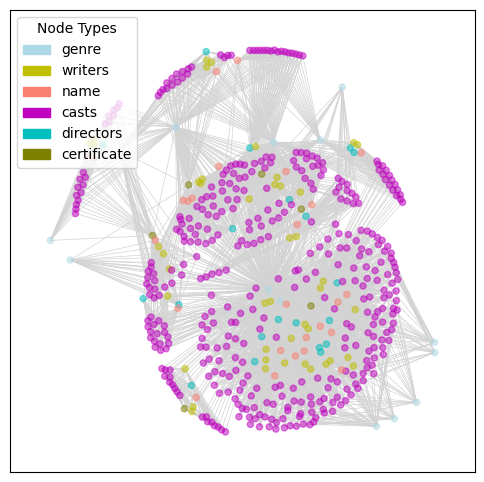

In [207]:
G = add_edges(categories, df_restricted, G)
show_graph(G, categories)


---

#### Use Graph Operations

The network above doesn't actually match the graph schema since it shows nodes with types writers, directors, and cast members. The graph schema says that we should lump people in these categories into a generic type called _person_.  This section of the tutorial explores different types of graph operations. 

I'm going to use the term _projection_ for these different kinds of graph operations, though I don't think most people would agree with my use of this term. We'll look at a very specific type of projection which can be performed using incidence matrices. This kind of projection is technically called a _one-mode projection_, so I'm going to use the term _projection_ as a kind of "catch all" term to mean I'm going to manipulate the graph in some way to help me understand more about it.

The key to each type of projection is to notice that each node is in one of a set of unique classes. In other words, all nodes in the same `node_type` form a subset of all nodes. Splitting up nodes into different subsets according to their node_type forms a _partition_ of the set. The projections we will discuss operate on the different classes within a partition.

**Bipartitie Graphs:** Recall that a bipartite network is a graph where nodes can be partitioned into two classes. Edges only form between nodes in different classes, and never form between nodes from within the same class. We can construct bipartite graphs for any of the categories in our database as long as there is a node between the categories. For example, we can construct a bipartite graph with what actors are in what movies.

438


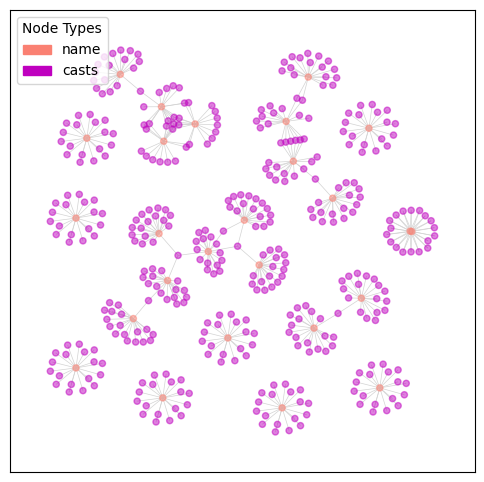

In [214]:
categories: set[str] = {'name', 'casts'}
G_name_cast: nx.Graph = nx.Graph()
G_name_cast = get_nodes_from_categories(categories, df_restricted, G_name_cast) 
G_name_cast = add_edges(categories, df_restricted, G_name_cast)

print(len(G_name_cast))
show_graph(G_name_cast, categories)

432


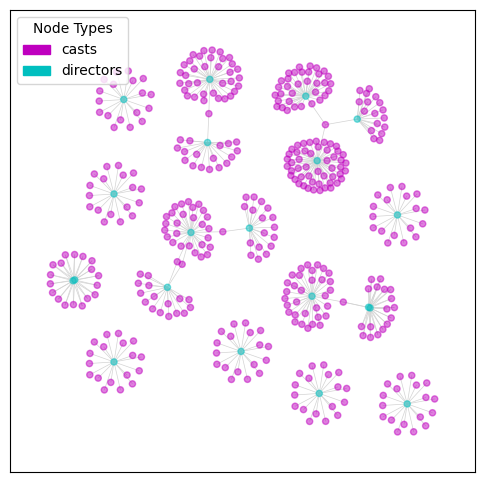

In [215]:
categories: set[str] = {'directors', 'casts'}
G_director_cast: nx.Graph = nx.Graph()
G_director_cast = get_nodes_from_categories(categories, df_restricted, G_director_cast) 
G_director_cast = add_edges(categories, df_restricted, G_director_cast)

print(len(G_director_cast))
show_graph(G_director_cast, categories)

70


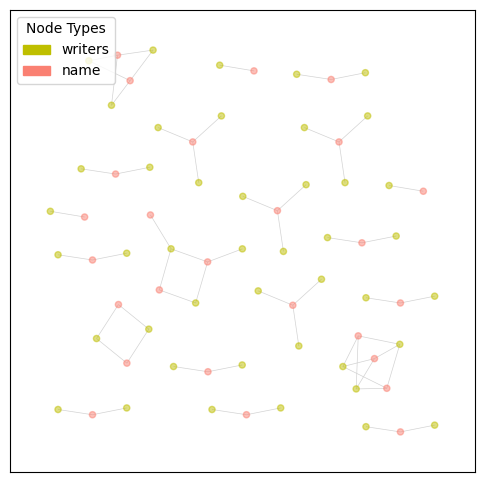

In [216]:
categories: set[str] = {'name', 'writers'}
G_name_writer: nx.Graph = nx.Graph()
G_name_writer = get_nodes_from_categories(categories, df_restricted, G_name_writer) 
G_name_writer = add_edges(categories, df_restricted, G_name_writer)

print(len(G_name_writer))
show_graph(G_name_writer, categories)

**Bipartite Graph Representations:** ry to recall when we talked about bipartite graphs near the start of the semester. We were able to come up with a special type of matrix representation. The rows represented vertices in the first partition and the columns represented vertices in the second partition.

<img src="figures/BipartiteGraph_IncidenceMatrix.png" alt="Special form of the incidence matrix for a bipartite graph" width = "500">



**Joining Classes:** 

In [218]:
import networkx as nx
import numpy as np
import scipy.sparse as sp
from networkx.algorithms import bipartite

# Step 1: Create a Bipartite Graph
B = nx.Graph()

# Define two sets of nodes
movies = {"Inception", "Interstellar", "The Dark Knight"}
people = {"Christopher Nolan", "Leonardo DiCaprio", "Matthew McConaughey", "Christian Bale", "Jonathan Nolan"}

# Add nodes with a 'bipartite' attribute
B.add_nodes_from(movies, bipartite=0)  # Movies as one class
B.add_nodes_from(people, bipartite=1)  # People as another class

# Step 2: Add edges (connections between movies and people)
edges = [
    ("Inception", "Christopher Nolan"),
    ("Inception", "Leonardo DiCaprio"),
    ("Inception", "Jonathan Nolan"),
    ("Interstellar", "Christopher Nolan"),
    ("Interstellar", "Matthew McConaughey"),
    ("Interstellar", "Jonathan Nolan"),
    ("The Dark Knight", "Christopher Nolan"),
    ("The Dark Knight", "Christian Bale"),
    ("The Dark Knight", "Jonathan Nolan")
]

B.add_edges_from(edges)

# Step 3: Find the incidence matrix (biadjacency matrix)
# The rows correspond to movies, columns correspond to people
movies_list = list(movies)
people_list = list(people)

incidence_matrix = nx.bipartite.biadjacency_matrix(B, row_order=movies_list, column_order=people_list)

# Convert to dense NumPy array for better visualization
incidence_array = incidence_matrix.toarray()

# Step 4: Split the incidence matrix by class
movies_matrix = incidence_array  # Rows: movies, Columns: people
people_matrix = incidence_array.T  # Transpose to get people as rows

# Print matrices
print("Incidence Matrix (Movies as Rows, People as Columns):")
print(movies_matrix)

print("\nIncidence Matrix (People as Rows, Movies as Columns):")
print(people_matrix)

Incidence Matrix (Movies as Rows, People as Columns):
[[1 1 0 0 1]
 [1 1 1 0 0]
 [1 1 0 1 0]]

Incidence Matrix (People as Rows, Movies as Columns):
[[1 1 1]
 [1 1 1]
 [0 1 0]
 [0 0 1]
 [1 0 0]]
